In [1]:
import sys
import os
import json
import pandas as pd 
import matplotlib.pyplot as plt
# script_dir = os.path.dirname(os.path.abspath(__file__))
common_dir =os.getenv("COMMON_SCRIPT_DIR")
sys.path.insert(0, common_dir)
from metaphlan import get_abundance,get_metadata,rename_taxonomy,get_abundance0
os.chdir(os.getenv("OUTPUT_DIR"))
import seaborn as sns
from statannotations.Annotator import Annotator
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import mannwhitneyu  
from matplotlib_venn import venn2


params_path = sys.argv[1]
output_path = sys.argv[2]
params_path="params.json"
output_path="output"



# In[14]:


# pip install statannotations


# In[4]:


with open(params_path) as f:
    data = json.load(f)


In [2]:
rank = data["rank"]
rank

'SPECIES'

In [3]:
# calculation_method = data["calculation_method"]
# calculation_method

In [4]:
query = data["query"]
query

['Prevalent in both sites', 'Prevalent in oral-SCZ-oral-HC']

In [5]:
# hypothesis = data["hypothesis"]
# hypothesis

In [6]:
# sites_samples = sum([data[group] for group in ["sites1","sites2"]],[])
# sites_samples

In [7]:
abundance0 = get_abundance(data,rename=False,filter=["sites1","sites2"])
metadata = get_metadata(data,filter=["sites1","sites2"])


In [9]:
abundance= abundance0[abundance0.index.get_level_values("rank")==rank].reset_index(["clade_name","ncbi_tax_id","tax_id","rank"],drop=True)
abundance

,F-30-156,F-30-115,F-30-D-053,F-30-D-077,F-30-D-010,F-30-125,F-30-D-072,F-30-D-025,F-30-D-030,F-30-100,...,S-30-147,S-30-D-071,S-30-173,S-30-153,S-30-103,S-30-D-028,S-30-D-048,S-30-133,S-30-D-014,S-30-D-010
taxonomy,,,,,,,,,,,,,,,,,,,,,
s__GGB519_SGB697,0.0,0.00000,0.00334,0.00000,0.0,0.0000,0.0,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s__GGB532_SGB711,0.0,0.00000,0.00000,0.00000,0.0,0.0000,0.0,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s__Methanobrevibacter_arboriphilus,0.0,0.00000,0.00000,0.00000,0.0,0.0000,0.0,0.00000,0.00122,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s__Methanobrevibacter_oralis,0.0,0.00000,0.00000,0.00000,0.0,0.0000,0.0,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s__Methanobrevibacter_smithii,0.0,0.00000,0.00000,0.00000,0.0,0.0000,0.0,0.00000,0.00000,0.00248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s__Mycoplasma_amphoriforme,0.0,0.00000,0.00000,0.00000,0.0,0.0000,0.0,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s__GGB6127_SGB8773,0.0,0.00000,0.00000,0.00000,0.0,0.0000,0.0,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s__Puniceicoccaceae_unclassified_SGB8769,0.0,0.00000,0.00000,0.00000,0.0,0.0000,0.0,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
sites1= data["groups_name"]['sites1']
sites2= data["groups_name"]['sites2']

In [11]:
sites1

'faeces-SCZ-faeces-HC'

In [12]:
abundance[sites1]  = abundance[metadata.query("group==@sites1").index].apply(lambda x: sum(x!=0)/len(x)*100 ,axis=1)
abundance[sites2]  = abundance[metadata.query("group==@sites2").index].apply(lambda x: sum(x!=0)/len(x)*100 ,axis=1)
abundance_prev = abundance[[sites1,sites2]]


In [13]:

def set_type(control_prev, treatment_prev,control_group,treatment_group):
    if control_prev>= 10 and treatment_prev>=10:
        return f"Prevalent in both sites"
    elif control_prev>= 10 and treatment_prev<10:
        return f"Prevalent in {control_group}"
    elif control_prev< 10 and treatment_prev>=10:
        return f"Prevalent in {treatment_group}"
    else:
        return "Not prevalent in either sites"

In [14]:
abundance_prev['type'] = abundance_prev.apply(lambda x: set_type(x[sites1],x[sites2],sites1,sites2),axis=1)


/tmp/ipykernel_433/979037496.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abundance_prev['type'] = abundance_prev.apply(lambda x: set_type(x[sites1],x[sites2],sites1,sites2),axis=1)


In [15]:
prev_data = abundance_prev['type'].value_counts()

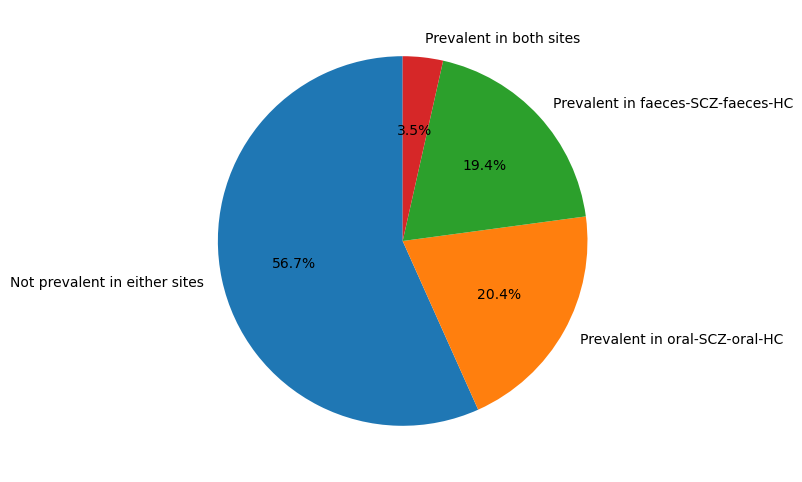

In [16]:

plt.figure(figsize=(8, 6))
prev_data.plot.pie(autopct='%.1f%%', figsize=(6, 6), startangle=90)
plt.ylabel('')
plt.savefig(f"{output_path}/pie.pdf", bbox_inches="tight")


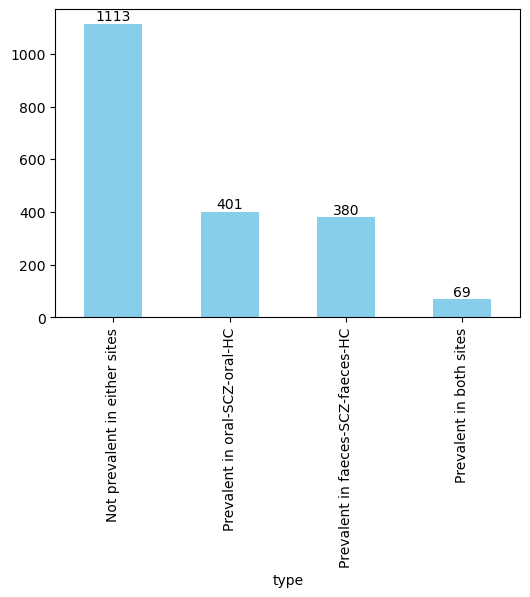

In [17]:
plt.figure(figsize=(8, 6))
ax = prev_data.plot(kind='bar', figsize=(6,4), color='skyblue')
for i, v in enumerate(prev_data):
    ax.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=10)
plt.savefig(f"{output_path}/bar.pdf", bbox_inches="tight")


In [46]:
abundance_prev.reset_index()

,taxonomy,faeces-SCZ-faeces-HC,oral-SCZ-oral-HC,type
0,s__GGB519_SGB697,0.757576,0.000000,Not prevalent in either sites
1,s__GGB532_SGB711,2.272727,0.000000,Not prevalent in either sites
2,s__Methanobrevibacter_arboriphilus,1.515152,0.000000,Not prevalent in either sites
3,s__Methanobrevibacter_oralis,0.757576,4.225352,Not prevalent in either sites
4,s__Methanobrevibacter_smithii,4.545455,0.000000,Not prevalent in either sites
...,...,...,...,...
1958,s__Mycoplasma_amphoriforme,0.000000,0.704225,Not prevalent in either sites
1959,s__GGB6127_SGB8773,1.515152,0.000000,Not prevalent in either sites
1960,s__Puniceicoccaceae_unclassified_SGB8769,0.757576,0.000000,Not prevalent in either sites
1961,s__Akkermansia_muciniphila,29.545455,0.704225,Prevalent in faeces-SCZ-faeces-HC


In [49]:
# set(merge_faeces_oral_long['type'])

{'Not prevalent in either sites',
 'Prevalent in both sites',
 'Prevalent in faeces-SCZ-faeces-HC',
 'Prevalent in oral-SCZ-oral-HC'}

In [68]:
# data["groups_name"]["sites1"]

In [65]:
sites1_name = data["groups_name"]["sites1"]
sites2_name = data["groups_name"]["sites2"]

In [67]:
categories=[f"Prevalent in {sites1_name}",'Prevalent in both sites',f"Prevalent in {sites2_name}"]
categories

['Prevalent in faeces-SCZ-faeces-HC',
 'Prevalent in both sites',
 'Prevalent in oral-SCZ-oral-HC']

In [79]:
merge_faeces_oral_long = pd.melt(abundance_prev.reset_index(), id_vars=['taxonomy','type'], var_name='site', value_name='prev')

merge_faeces_oral_long = merge_faeces_oral_long[merge_faeces_oral_long['type']!='Not prevalent in either sites']
merge_faeces_oral_long['prev'] = merge_faeces_oral_long.apply(lambda x: x['prev'] if x['site']==sites1_name else -x["prev"],axis=1)
merge_faeces_oral_long['type'] = pd.Categorical(merge_faeces_oral_long['type'], categories=categories, ordered=True)
merge_faeces_oral_long = merge_faeces_oral_long.sort_values(by=['type'])
merge_faeces_oral_long

,taxonomy,type,site,prev
1962,s__Saccharomyces_cerevisiae,Prevalent in faeces-SCZ-faeces-HC,faeces-SCZ-faeces-HC,17.424242
2151,s__Bacteroides_intestinalis,Prevalent in faeces-SCZ-faeces-HC,oral-SCZ-oral-HC,-0.000000
2154,s__Bacteroides_nordii,Prevalent in faeces-SCZ-faeces-HC,oral-SCZ-oral-HC,-0.000000
2155,s__Bacteroides_ovatus,Prevalent in faeces-SCZ-faeces-HC,oral-SCZ-oral-HC,-2.816901
2158,s__Bacteroides_salyersiae,Prevalent in faeces-SCZ-faeces-HC,oral-SCZ-oral-HC,-0.000000
...,...,...,...,...
1791,s__Campylobacter_SGB96342,Prevalent in oral-SCZ-oral-HC,faeces-SCZ-faeces-HC,0.000000
1790,s__Campylobacter_SGB19347,Prevalent in oral-SCZ-oral-HC,faeces-SCZ-faeces-HC,0.000000
1789,s__Campylobacter_SGB19337,Prevalent in oral-SCZ-oral-HC,faeces-SCZ-faeces-HC,0.757576
1812,s__Cardiobacterium_SGB9420,Prevalent in oral-SCZ-oral-HC,faeces-SCZ-faeces-HC,0.000000


In [75]:
# merge_faeces_oral_long['taxonomy'].to_list()

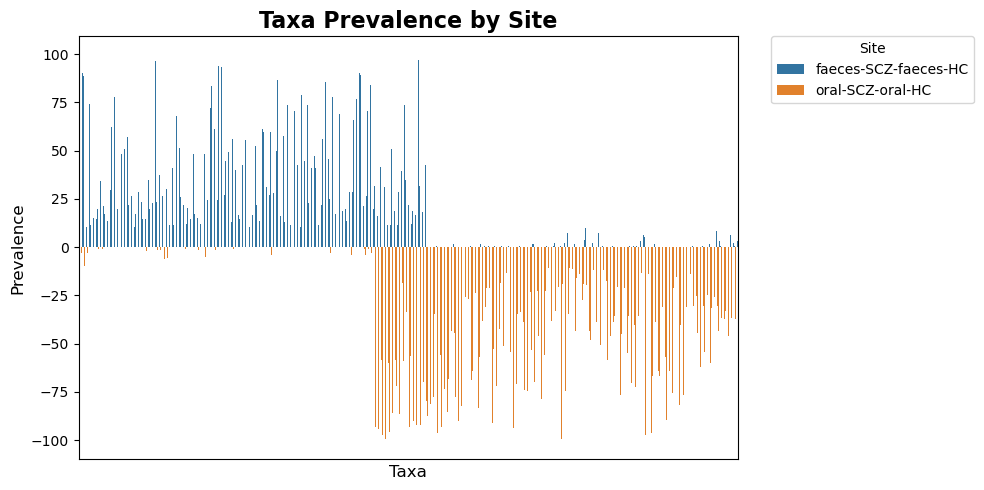

In [87]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data=merge_faeces_oral_long,
    x='taxonomy',
    y='prev',
    hue='site',
    order=merge_faeces_oral_long['taxonomy'].to_list()
)

# 设置标题更大
plt.title('Taxa Prevalence by Site', fontsize=16, weight='bold')

# 坐标轴标签
plt.ylabel('Prevalence', fontsize=12)
plt.xlabel('Taxa', fontsize=12)

# 去掉 x 轴刻度
plt.xticks([])

# 图例放在右边外部
plt.legend(
    title='Site',
    bbox_to_anchor=(1.05, 1),   # (x, y) 控制图例位置
    loc='upper left',           # 图例锚点位置
    borderaxespad=0.
)

plt.tight_layout()
plt.savefig(f"{output_path}/prevalence.pdf", bbox_inches="tight")

In [89]:
# plt.figure(figsize=(8, 5))
# sns.barplot(data=merge_faeces_oral_long, x='taxonomy', y='prev', hue='site',order=merge_faeces_oral_long['taxonomy'].to_list())

# plt.title('Taxa Prevalence by Site')
# plt.ylabel('Prevalence')
# plt.xlabel('Taxa')
# plt.xticks([])
# plt.tight_layout()
# # plt.show()
# plt.savefig(f"{output_path}/prevalence.pdf", bbox_inches="tight")

In [18]:
abundance_prev_filter = abundance_prev.query("type in @query")

In [19]:
abundance_prev_filter

,faeces-SCZ-faeces-HC,oral-SCZ-oral-HC,type
taxonomy,,,
s__Actinobaculum_sp_oral_taxon_183,23.484848,79.577465,Prevalent in both sites
s__Actinomyces_SGB17132,21.969697,71.830986,Prevalent in both sites
s__Actinomyces_bouchesdurhonensis,15.909091,31.690141,Prevalent in both sites
s__Actinomyces_dentalis,50.757576,85.915493,Prevalent in both sites
s__Actinomyces_gerencseriae,6.060606,37.323944,Prevalent in oral-SCZ-oral-HC
...,...,...,...
s__GGB42243_SGB69463,0.000000,14.084507,Prevalent in oral-SCZ-oral-HC
s__GGB49518_SGB69462,0.000000,37.323944,Prevalent in oral-SCZ-oral-HC
s__GGB4333_SGB5935,0.757576,73.943662,Prevalent in oral-SCZ-oral-HC


In [20]:
taxonomy = abundance_prev_filter.index
in_select_stats = abundance_prev['type'].value_counts()

In [21]:
abundance_1 = get_abundance(data,rename=False,filter=["treatment","control"])
metadata_1  = get_metadata(data,filter=["treatment","control"])
abundance_1= abundance_1[abundance_1.index.get_level_values("rank")==rank].reset_index(["clade_name","ncbi_tax_id","tax_id","rank"],drop=True).T


In [22]:
safe_cols = [col for col in taxonomy  if col in abundance_1.columns]

In [23]:
abundance_2 = abundance_1[safe_cols]

In [24]:
# if calculation_method=="sum":
#     df_cumulative =  pd.DataFrame(abundance_2.sum(axis=1)).rename({0:"abundance"},axis=1)
# elif calculation_method=="count":
#     df_cumulative =  pd.DataFrame((abundance_2!=0).sum(axis=1)).rename({0:"abundance"},axis=1)

In [25]:
df_cumulative_sum =  pd.DataFrame(abundance_2.sum(axis=1)).rename({0:"abundance_sum"},axis=1)
df_cumulative_count =  pd.DataFrame((abundance_2!=0).sum(axis=1)).rename({0:"abundance_count"},axis=1)

In [26]:
df_cumulative = pd.merge(df_cumulative_sum,df_cumulative_count,left_index=True,right_index=True)

In [27]:
df_cumulative = pd.merge(df_cumulative,metadata_1,left_index=True,right_index=True,how="left")
df_cumulative

,abundance_sum,abundance_count,group
F-30-156,7.45559,3,faeces-SCZ
F-30-115,11.39970,37,faeces-SCZ
F-30-125,25.84384,33,faeces-SCZ
F-30-100,1.55971,26,faeces-SCZ
F-30-123,3.12880,56,faeces-SCZ
...,...,...,...
F-30-D-073,1.48385,31,faeces-HC
F-30-D-049,34.43272,17,faeces-HC
F-30-D-066,26.20653,20,faeces-HC
F-30-D-013,4.11269,16,faeces-HC


In [28]:
df_cumulative.to_csv(f"{output_path}/cumulative_abundance.tsv",sep="\t",index=False)


In [29]:
custom_palette = {
    data["groups_name"]["control"]: "#66c2a5",
    data["groups_name"]["treatment"]: "#fc8d62"
}


In [30]:
data["groups_name"]["control"]

'faeces-HC'

/tmp/ipykernel_433/971462318.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='group', y='abundance_sum', data=df_cumulative,


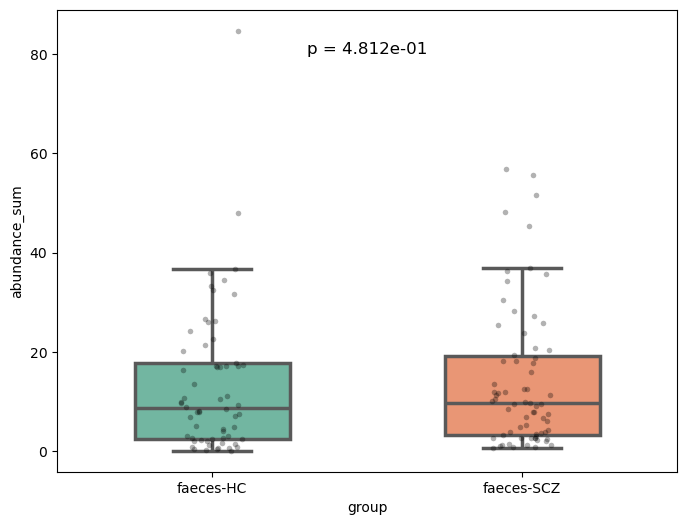

In [31]:
control = df_cumulative[df_cumulative['group']==data["groups_name"]["control"] ]['abundance_sum'].to_list()
treatment = df_cumulative[df_cumulative['group']==data["groups_name"]["treatment"] ]['abundance_sum'].to_list()
stat, p_value = mannwhitneyu(control, treatment, alternative='two-sided') 
plt.figure(figsize=(8, 6))
# df_cumulative['abundance'] = np.log(df_cumulative['abundance'])
ax = sns.boxplot(x='group', y='abundance_sum', data=df_cumulative, 
            width=0.5,       # 箱体宽度
            linewidth=2.5,
            palette=custom_palette,
            order=[data["groups_name"]["control"],data["groups_name"]["treatment"]],
            showfliers=False
           )    # 
sns.stripplot(x='group', y='abundance_sum', data=df_cumulative,  # 叠加散点图
              color='black', size=4, alpha=0.3)
y_min,y_max = ax.get_ylim()
plt.text(x=0.5, y=y_max*0.9, s=f"p = {p_value:.3e}", ha="center", fontsize=12)
plt.savefig(f"{output_path}/boxplot.sum.abundance.pdf", bbox_inches="tight")



/tmp/ipykernel_433/1658269514.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = model.pvalues[1]
/tmp/ipykernel_433/1658269514.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='group', y='abundance_count', data=df_cumulative,


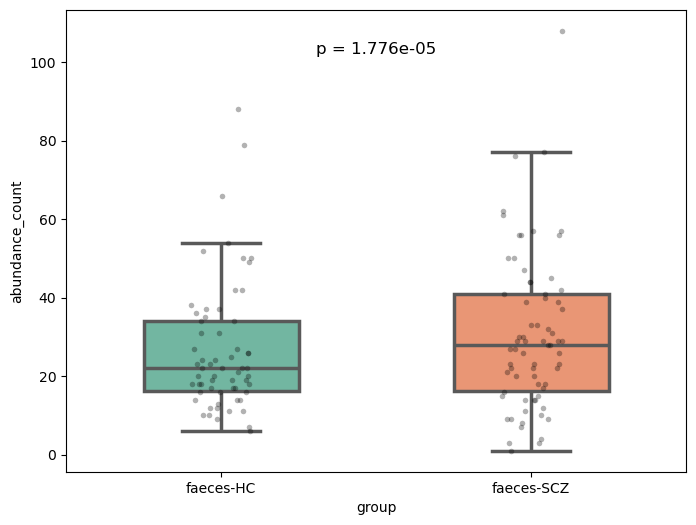

In [32]:
control = df_cumulative[df_cumulative['group']==data["groups_name"]["control"] ]['abundance_count'].to_list()
treatment = df_cumulative[df_cumulative['group']==data["groups_name"]["treatment"] ]['abundance_count'].to_list()
model = smf.glm(formula="abundance_count ~ group", data=df_cumulative, family=sm.families.Poisson()).fit()
p_value = model.pvalues[1]

plt.figure(figsize=(8, 6))
# df_cumulative['abundance'] = np.log(df_cumulative['abundance'])
ax = sns.boxplot(x='group', y='abundance_count', data=df_cumulative, 
            width=0.5,       # 箱体宽度
            linewidth=2.5,
           palette=custom_palette,
            order=[data["groups_name"]["control"],data["groups_name"]["treatment"]],
           showfliers=False
           )    # 
sns.stripplot(x='group', y='abundance_count', data=df_cumulative,  # 叠加散点图
              color='black', size=4, alpha=0.3)
y_min,y_max = ax.get_ylim()
plt.text(x=0.5, y=y_max*0.9, s=f"p = {p_value:.3e}", ha="center", fontsize=12)
plt.savefig(f"{output_path}/boxplot.count.pdf", bbox_inches="tight")



In [33]:
# p_value=None
# if hypothesis=="mannwhitneyu":
#     stat, p_value = mannwhitneyu(control, treatment, alternative='two-sided') 
# elif  hypothesis=="poisson":
    # model = smf.glm(formula="abundance ~ group", data=df_cumulative, family=sm.families.Poisson()).fit()
    # p_value = model.pvalues[1]

In [34]:
# in_venn = {
#     "detection":set(abundance.columns),
#     "select":set(taxonomy)
# }

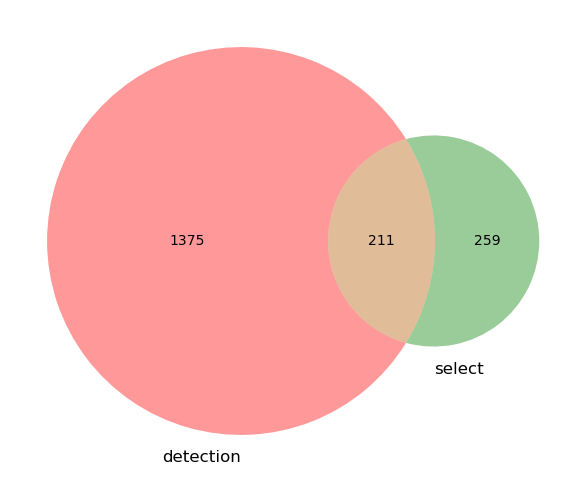

In [38]:
plt.figure(figsize=(8, 6))
venn2(subsets=[set(abundance_1.columns), set(taxonomy)], set_labels = ('detection', 'select'))
plt.savefig(f"{output_path}/venn.pdf", bbox_inches="tight")
